In [2]:
import yfinance as yf
import pandas as pd

sp500_tickers = pd.read_csv("../data/sp500_tickers.csv")
sp500_tickers['Symbol'] = sp500_tickers['Symbol'].str.replace('.', '-', regex=False)

# Download historical data for all S&P 500 tickers
today = pd.Timestamp.today().strftime('%Y-%m-%d')
data = yf.download(sp500_tickers['Symbol'].tolist(), start="2020-01-01", end=today, auto_adjust=True)

print(data.columns.levels)
print(data.columns)

[*********************100%***********************]  502 of 503 completed

1 Failed download:
['ADM']: Timeout('Failed to perform, curl: (28) Operation timed out after 10004 milliseconds with 22935 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*********************100%***********************]  502 of 503 completed

[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', ...]]
MultiIndex([('Adj Close',  'ADM'),
            (    'Close',    'A'),
            (    'Close', 'AAPL'),
            (    'Close', 'ABBV'),
            (    'Close', 'ABNB'),
            (    'Close',  'ABT'),
    

In [3]:
from tqdm import tqdm  # progress bar

signals = []

for ticker in tqdm(sp500_tickers['Symbol']):
    try:
        df = data.xs(ticker, level=1, axis=1).copy()
        df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3
        df['TPV'] = df['TypicalPrice'] * df['Volume']
        df['Cum_TPV'] = df['TPV'].cumsum()
        df['Cum_Volume'] = df['Volume'].cumsum()
        df['VWAP'] = df['Cum_TPV'] / df['Cum_Volume']

        # Swing low in last 30 bars
        recent_lows = df['Low'].iloc[-30:]
        anchor_date = recent_lows.idxmin()

        anchored_df = df.loc[anchor_date:].copy()
        anchored_df['AVWAP'] = (
            (anchored_df['TypicalPrice'] * anchored_df['Volume']).cumsum() /
            anchored_df['Volume'].cumsum()
        )

        df.loc[anchor_date:, 'AVWAP'] = anchored_df['AVWAP']
        df['AVWAP_Slope'] = df['AVWAP'].diff()

        latest = df.iloc[-1]

        # Signal logic
        if (
            latest['Close'] > latest['AVWAP'] and
            latest['AVWAP_Slope'] > 0 and
            latest['Close'] < latest['AVWAP'] * 1.05
        ):
            signals.append({
                'Symbol': ticker,
                'Close': latest['Close'],
                'AVWAP': latest['AVWAP'],
                'DistanceToAVWAP': (latest['Close'] - latest['AVWAP']) / latest['AVWAP'],
                'AVWAP_Slope': latest['AVWAP_Slope'],
                'AnchorDate': anchor_date
            })

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

  0%|          | 0/503 [00:00<?, ?it/s]/var/folders/z7/l5mfp8zs6735wdd4hn4drvt80000gn/T/ipykernel_12978/3907181715.py:16: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  anchor_date = recent_lows.idxmin()
100%|██████████| 503/503 [00:00<00:00, 750.83it/s]


In [4]:
signals_df = pd.DataFrame(signals)
top_signals = signals_df.sort_values(by=['AVWAP_Slope', 'DistanceToAVWAP'], ascending=[False, True]).head(5)
print(top_signals)

    Symbol        Close        AVWAP  DistanceToAVWAP  AVWAP_Slope AnchorDate
186    NVR  7280.439941  7177.724057         0.014310     8.793162 2025-06-18
40    BKNG  5596.000000  5408.681991         0.034633     6.325052 2025-05-14
242    TPL  1075.449951  1053.660934         0.020679     6.136143 2025-06-24
223    NOW  1011.440002   995.044087         0.016478     3.619161 2025-06-23
268    WAT   354.910004   346.257770         0.024988     3.009683 2025-06-18


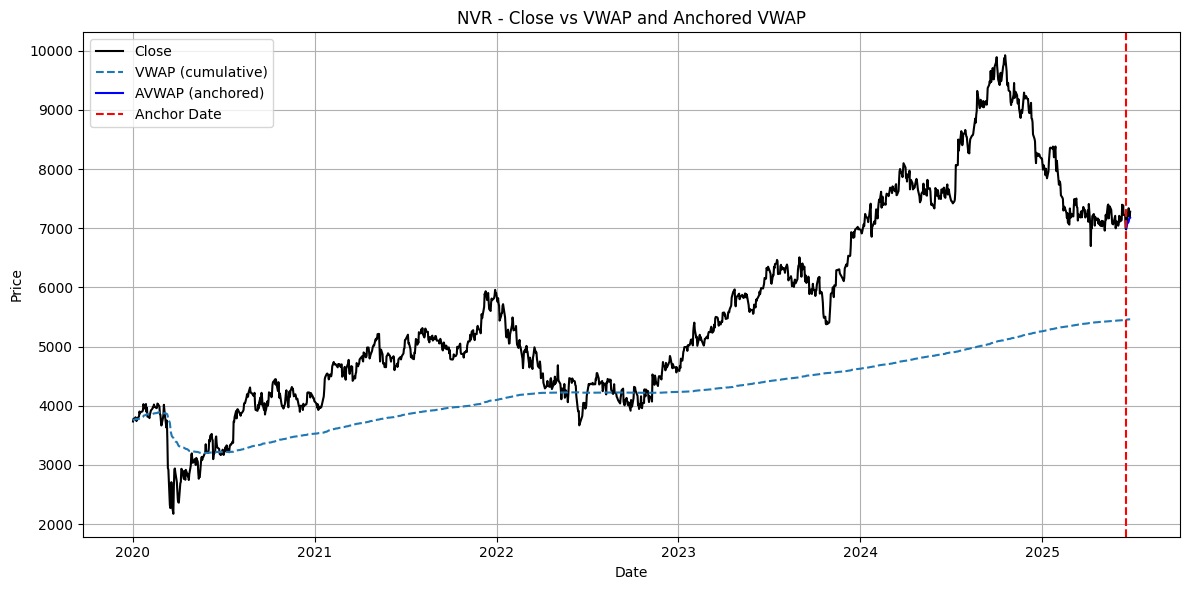

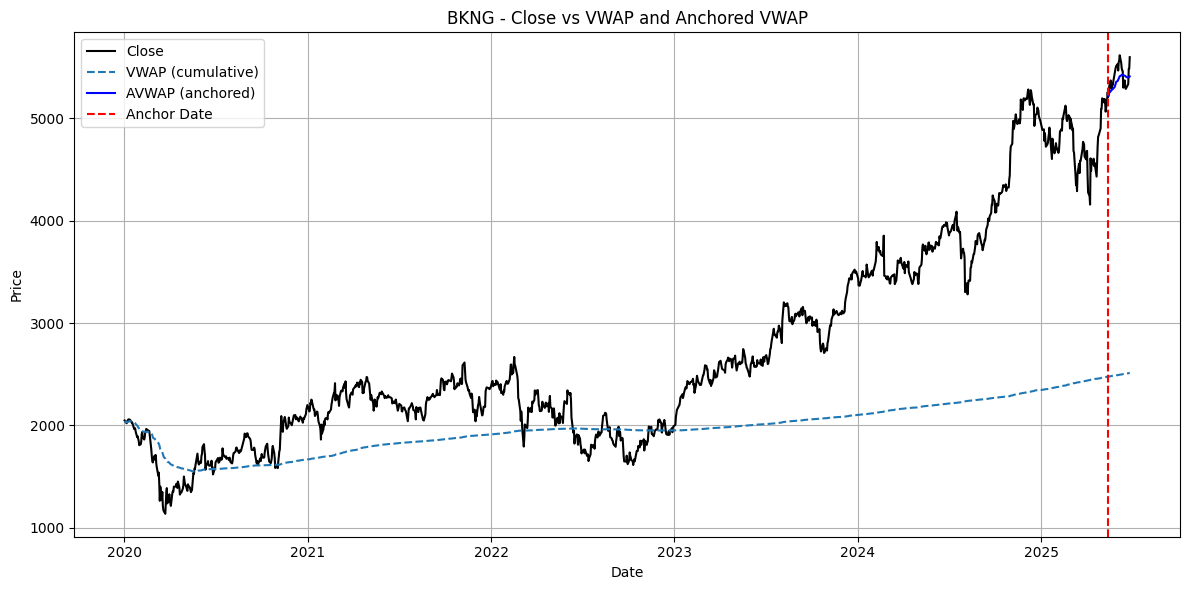

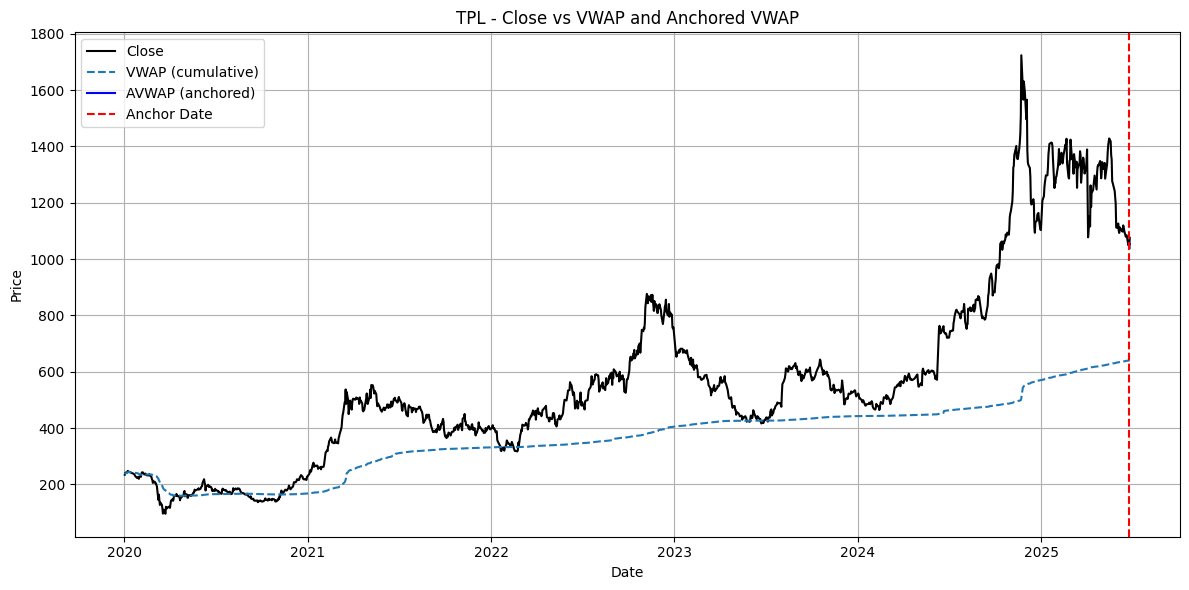

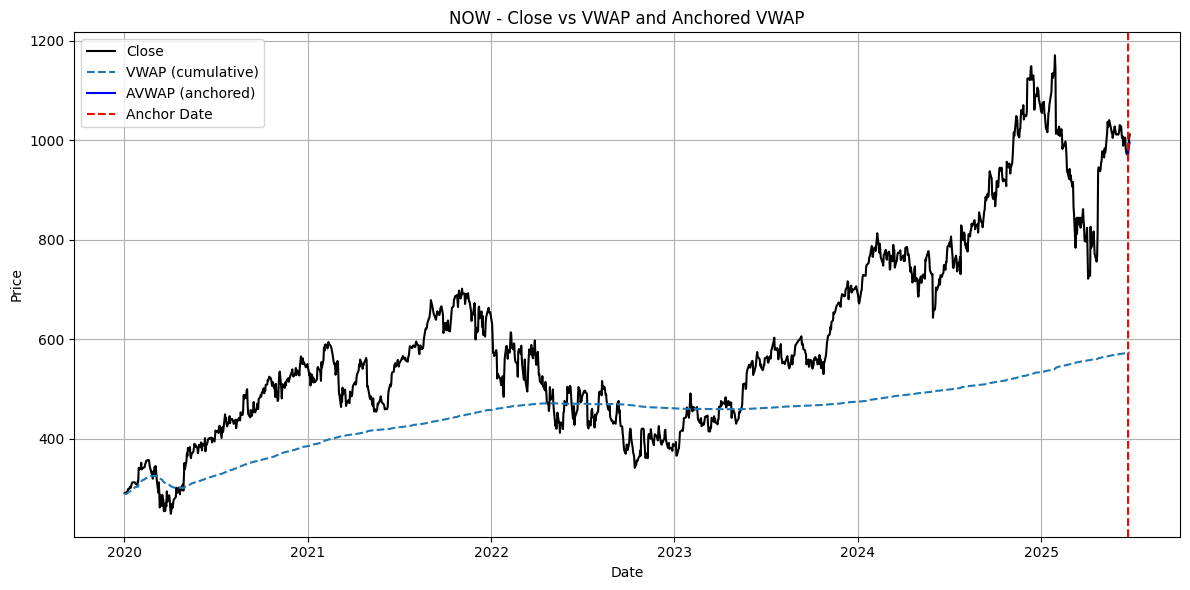

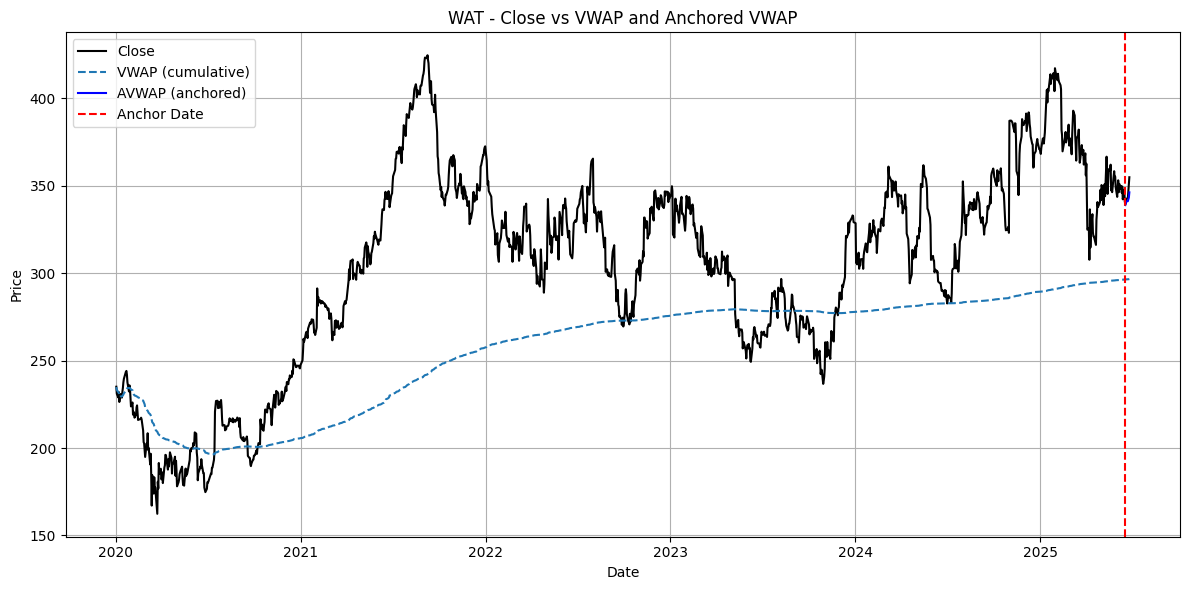

In [5]:
import matplotlib.pyplot as plt

for _, row in top_signals.iterrows():
    ticker = row['Symbol']
    try:
        # Get and process data for this ticker again (you could cache it earlier too)
        df = data.xs(ticker, level=1, axis=1).dropna().copy()
        df.columns = df.columns.str.title()

        df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3
        df['TPV'] = df['TypicalPrice'] * df['Volume']
        df['Cum_TPV'] = df['TPV'].cumsum()
        df['Cum_Volume'] = df['Volume'].cumsum()
        df['VWAP'] = df['Cum_TPV'] / df['Cum_Volume']

        anchor_date = row['AnchorDate']
        anchored_df = df.loc[anchor_date:].copy()
        anchored_df['AVWAP'] = (
            (anchored_df['TypicalPrice'] * anchored_df['Volume']).cumsum() /
            anchored_df['Volume'].cumsum()
        )
        df.loc[anchor_date:, 'AVWAP'] = anchored_df['AVWAP']

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'], label='Close', color='black')
        plt.plot(df.index, df['VWAP'], label='VWAP (cumulative)', linestyle='--')
        plt.plot(df.index, df['AVWAP'], label='AVWAP (anchored)', color='blue')
        plt.axvline(anchor_date, color='red', linestyle='--', label='Anchor Date')
        plt.title(f"{ticker} - Close vs VWAP and Anchored VWAP")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to plot {ticker}: {e}")


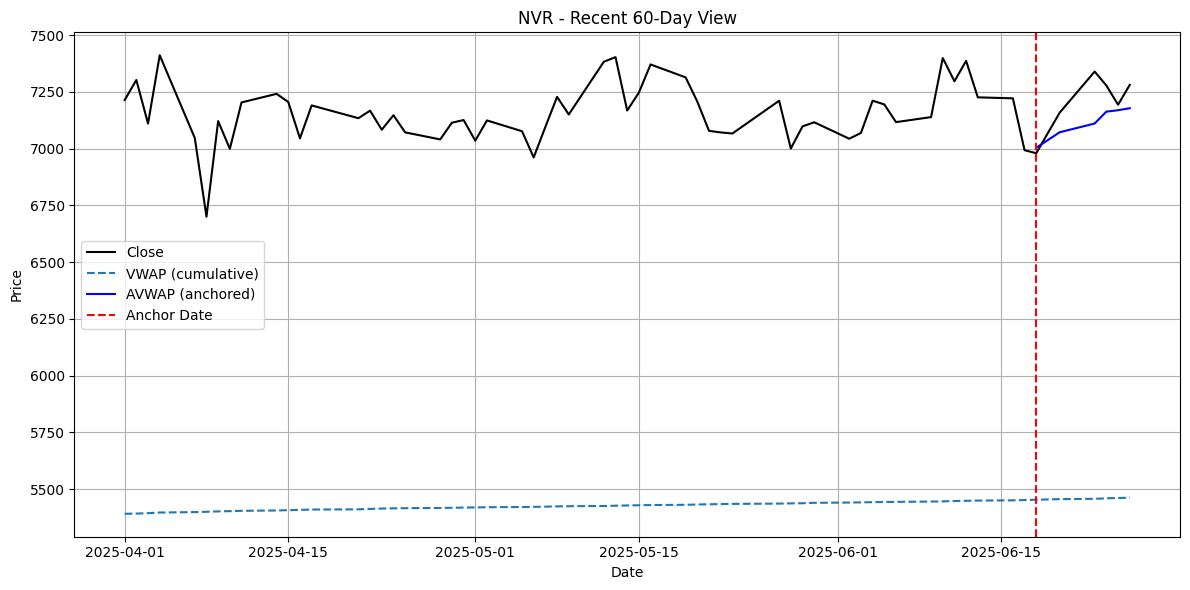

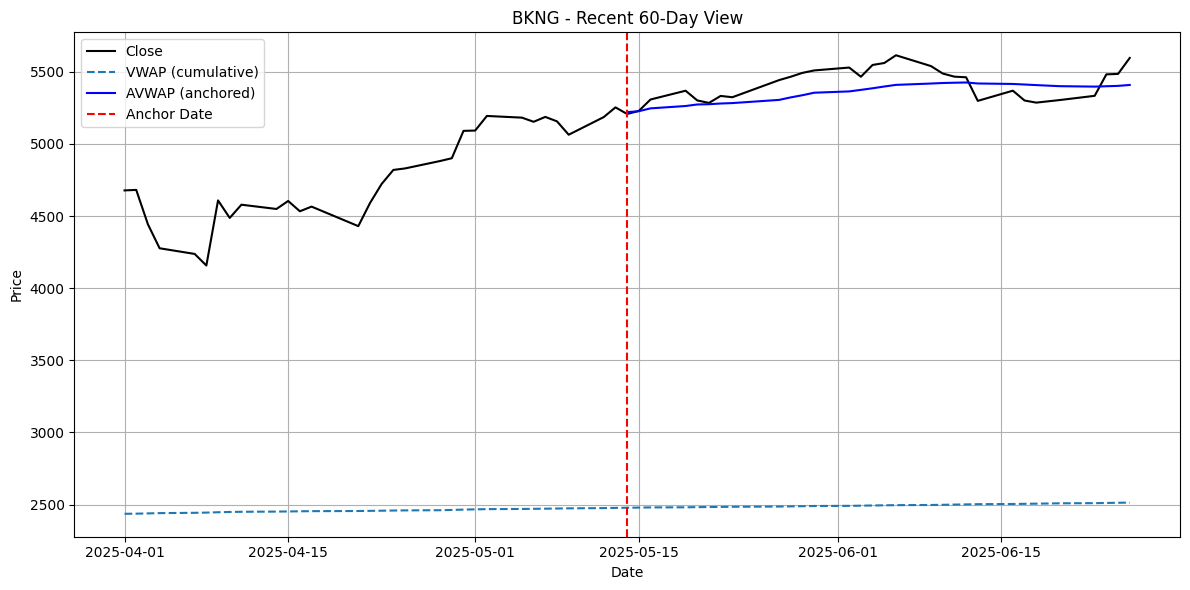

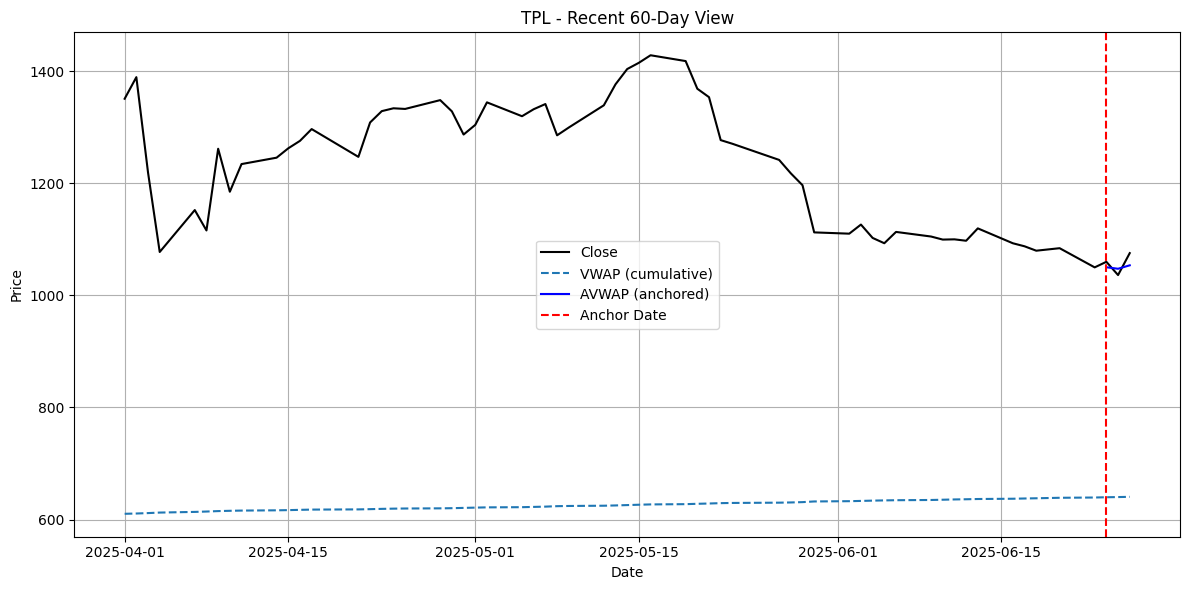

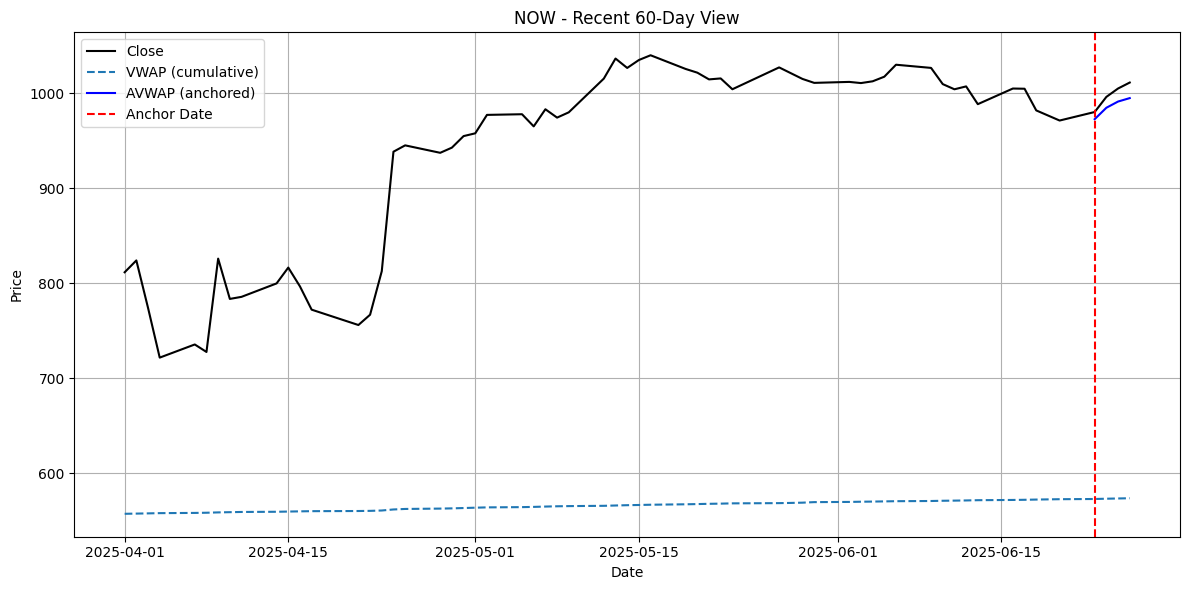

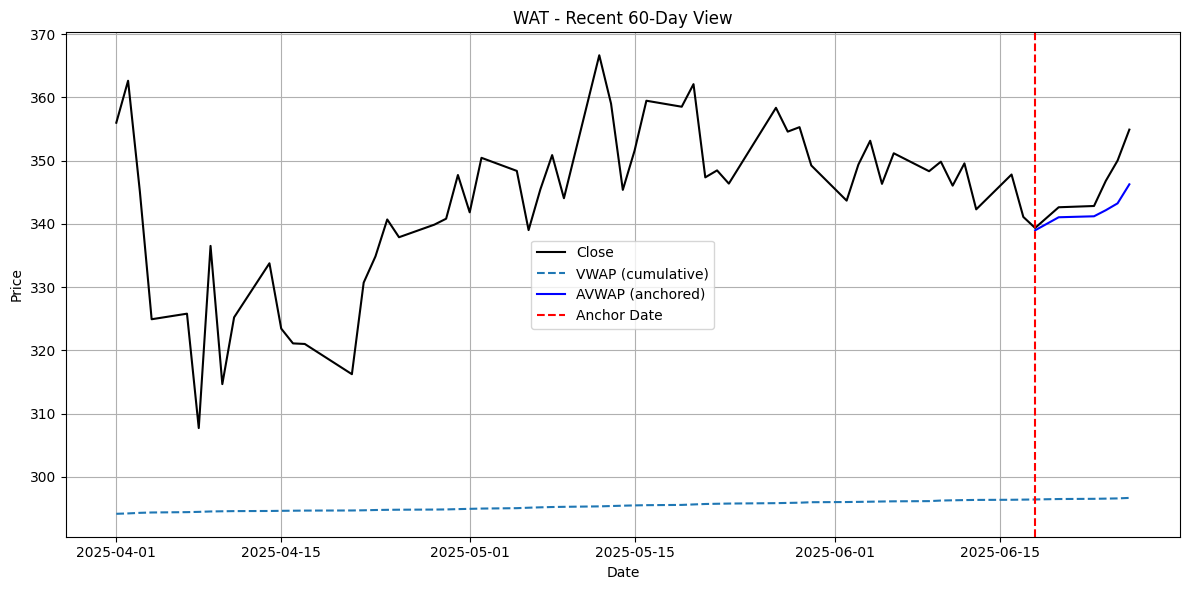

In [6]:
import matplotlib.pyplot as plt

for _, row in top_signals.iterrows():
    ticker = row['Symbol']
    try:
        # Get and process data for this ticker again (you could cache it earlier too)
        df = data.xs(ticker, level=1, axis=1).dropna().copy()
        df.columns = df.columns.str.title()

        df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3
        df['TPV'] = df['TypicalPrice'] * df['Volume']
        df['Cum_TPV'] = df['TPV'].cumsum()
        df['Cum_Volume'] = df['Volume'].cumsum()
        df['VWAP'] = df['Cum_TPV'] / df['Cum_Volume']

        anchor_date = row['AnchorDate']
        anchored_df = df.loc[anchor_date:].copy()
        anchored_df['AVWAP'] = (
            (anchored_df['TypicalPrice'] * anchored_df['Volume']).cumsum() /
            anchored_df['Volume'].cumsum()
        )
        df.loc[anchor_date:, 'AVWAP'] = anchored_df['AVWAP']

        # Plot
        recent_df = df.iloc[-60:].copy()

        plt.figure(figsize=(12, 6))
        plt.plot(recent_df.index, recent_df['Close'], label='Close', color='black')
        plt.plot(recent_df.index, recent_df['VWAP'], label='VWAP (cumulative)', linestyle='--')
        plt.plot(recent_df.index, recent_df['AVWAP'], label='AVWAP (anchored)', color='blue')
        plt.axvline(anchor_date, color='red', linestyle='--', label='Anchor Date')
        plt.title(f"{ticker} - Recent 60-Day View")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to plot {ticker}: {e}")
